Using device: cpu
L shape: torch.Size([10000, 10000]), L device: cpu


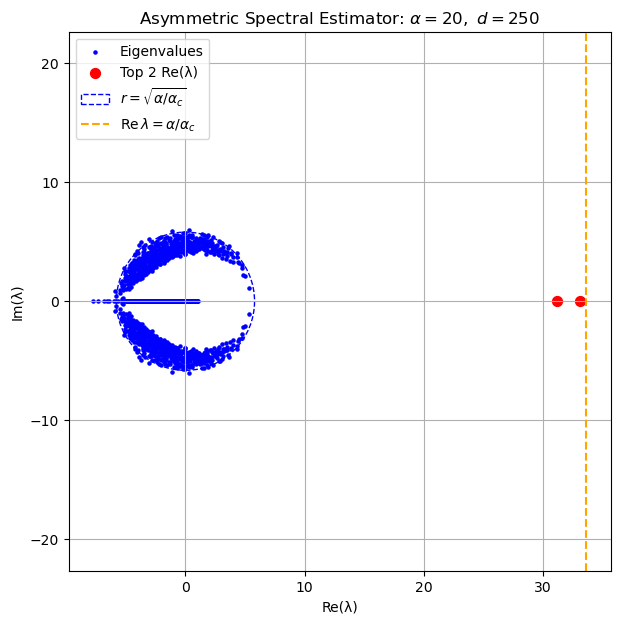

In [ ]:
import os
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import kv as besselk

# Fix random seed for reproducibility
def set_seed(seed=80):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(80)

# Parameters
n = 5000  # number of samples
p = 2     # subspace dimension
alpha = 20
alpha_c = 0.59375
d = int(n / alpha)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Generate input matrix X ∈ ℝ^{n×d}
X = torch.randn(n, d, device=device) / np.sqrt(d)

# Construct true subspace W* and observations Z = X W*
W_star = torch.randn(d, p, device=device)
Z = X @ W_star
z1, z2 = Z[:, 0], Z[:, 1]
y = z1 * z2  # link function

# Compute preprocessing function G(y) ∈ ℝ^{n×p×p}
y_cpu = y.detach().cpu().numpy()
abs_y = np.abs(y_cpu)
K1 = besselk(1, abs_y)
K0 = besselk(0, abs_y)
lambda_y = abs_y * (K1 / K0) - 1
lambda_y[np.isnan(lambda_y)] = 0  # numerical stability

# Construct G(y): 2×2 symmetric matrix per sample
G_y_np = np.zeros((n, p, p), dtype=np.float32)
G_y_np[:, 0, 0] = lambda_y
G_y_np[:, 1, 1] = lambda_y
G_y_np[:, 0, 1] = y_cpu
G_y_np[:, 1, 0] = y_cpu
G_y = torch.tensor(G_y_np, device=device)

# Build asymmetric spectral matrix L ∈ ℝ^{np×np}
XXT = X @ X.T  # (n, n)
XXT.fill_diagonal_(0.0)  # zero out diagonal

# Form block entries of L (iμ, jν)
A = XXT[:, :, None, None]            # (n, n, 1, 1)
G_broadcast = G_y[None, :, :, :]     # (1, n, p, p)
L_blocks = A * G_broadcast           # (n, n, p, p)
L = L_blocks.permute(0, 2, 1, 3).reshape(n * p, n * p)  # (np, np)
print(f"L shape: {L.shape}, L device: {L.device}")

# Compute eigenvalues (GPU) and plot
eigvals = torch.linalg.eigvals(L)
eigvals_np = eigvals.detach().cpu().numpy()
eigvals_real = eigvals_np.real

# Select the two largest by Re(λ)
top2_idx = np.argsort(eigvals_real)[-2:]
top2_vals = eigvals_np[top2_idx]

# Spectrum visualization
plt.figure(figsize=(7, 7))
plt.scatter(eigvals_np.real, eigvals_np.imag, s=5, color='blue', label='Eigenvalues')
plt.scatter(top2_vals.real, top2_vals.imag, color='red', s=50, label='Top 2 Re(λ)')

# Theoretical radius and threshold
r = np.sqrt(alpha / alpha_c)
thresh = alpha / alpha_c
circle = plt.Circle((0, 0), r, color='blue', fill=False, linestyle='--',
                    label=rf'$r = \sqrt{{\alpha / \alpha_c}}$')
plt.gca().add_artist(circle)
plt.axvline(x=thresh, color='orange', linestyle='--',
            label=rf'$\mathrm{{Re}}\,\lambda = \alpha / \alpha_c$')

# Plot settings
plt.xlabel('Re(λ)')
plt.ylabel('Im(λ)')
plt.title(rf'Asymmetric Spectral Estimator: $\alpha = {alpha},\ d = {d}$')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()


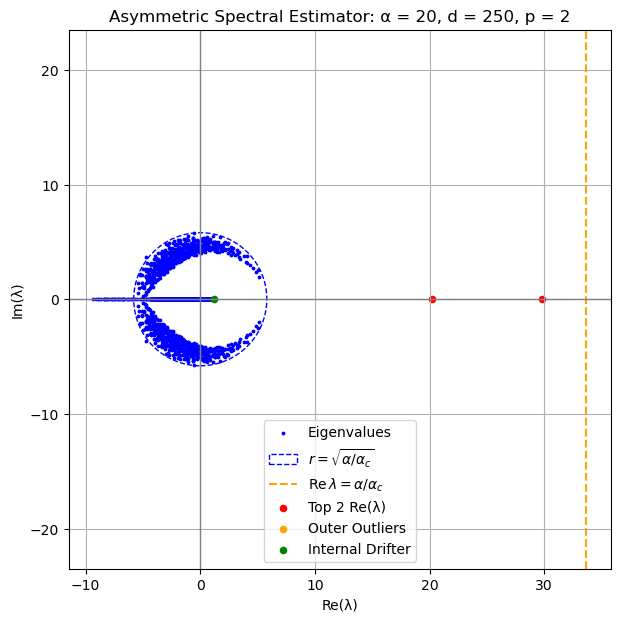

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from numpy.linalg import norm
from scipy.linalg import qr
import pandas as pd

# Overlap computation
def generalized_overlap_corrected(W_star, eigvals_np, eigvecs_np, target_vals, label_prefix, X):
    results = []
    d = W_star.shape[0]
    W_orth, _ = qr(W_star, mode='economic')  # Orthonormalize W*
    X_cpu = X.cpu().numpy().T  # (d, n)

    for i, val in enumerate(target_vals):
        idx = np.argmin(np.abs(eigvals_np - val))
        v_hat = eigvecs_np[:, idx]            # (n*p,)
        V = v_hat.reshape(-1, 2)              # (n, 2)

        U = X_cpu @ V                          # (d, 2)
        for j in range(2):
            u = U[:, j]
            u_hat = u / norm(u)
            q = norm(W_orth.T @ u_hat)**2
            results.append((f"{label_prefix}{i+1}-{j+1}", val, q))
    return results

# Pre-defined variables assumed:
# L (complex spectral matrix), alpha, alpha_c, W_star (d×2), X (n×d)

eigvals, eigvecs = torch.linalg.eig(L)
eigvals_np = eigvals.cpu().numpy()
eigvecs_np = eigvecs.cpu().numpy()
W_star_np = W_star.cpu().numpy()
d = W_star_np.shape[0]

R = np.sqrt(alpha / alpha_c)        # bulk spectral radius (blue circle)
thresh_ext = alpha / alpha_c        # vertical threshold (orange dashed)

# Eigenvalue classification
real_mask = np.isclose(eigvals_np.imag, 0.0, atol=1e-6)
eigvals_real_only = eigvals_np[real_mask]
real_parts = eigvals_real_only.real

# Top by real part
top10_real_idx = np.argsort(real_parts)[-10:]
top10_real_vals = eigvals_real_only[top10_real_idx]

# Red: two largest Re(λ)
red_vals = top10_real_vals[-2:]
rest_vals = top10_real_vals[:-2]

# Orange (outside) and green (inside) candidates
orange_vals = []
green_candidates = []
for val in rest_vals:
    if R < val.real < thresh_ext:
        orange_vals.append(val)
    elif val.real < R:
        green_candidates.append(val)

# Green selection: on real axis, inside circle, largest Re
green_vals = []
inside_real_mask = np.logical_and(
    np.abs(eigvals_np) <= R,
    np.isclose(eigvals_np.imag, 0.0, atol=1e-6)
)
eigvals_real_inside = eigvals_np[inside_real_mask]

if eigvals_real_inside.size >= 2:
    top2_idx = np.argsort(eigvals_real_inside.real)[-1:]  # keep as in original
    green_vals = [eigvals_real_inside[i] for i in top2_idx]
elif eigvals_real_inside.size == 1:
    green_vals = [eigvals_real_inside[0]]

# Visualization
plt.figure(figsize=(7, 7))
plt.scatter(eigvals_np.real, eigvals_np.imag, color="blue", s=3, label="Eigenvalues")

circle = plt.Circle((0, 0), R, color="blue", linestyle="--", fill=False, label=r"$r = \sqrt{\alpha/\alpha_c}$")
plt.gca().add_artist(circle)
plt.axvline(thresh_ext, color="orange", linestyle="--", label=r"$\mathrm{Re}\,\lambda = \alpha/\alpha_c$")

plt.scatter([z.real for z in red_vals], [z.imag for z in red_vals], color="red", s=20, label="Top 2 Re(λ)")
plt.scatter([z.real for z in orange_vals], [z.imag for z in orange_vals], color="orange", s=20, label="Outer Outliers")

# Green points
if len(green_vals) > 0:
    plt.scatter([z.real for z in green_vals], [z.imag for z in green_vals], color="green", s=20, label="Internal Drifter")

plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)
plt.xlabel("Re(λ)")
plt.ylabel("Im(λ)")
plt.title(f"Asymmetric Spectral Estimator: α = {alpha}, d = {d}, p = 2")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()


In [9]:
# ===============================
# 计算 overlap
# ===============================
results_red = generalized_overlap_corrected(W_star_np, eigvals_np, eigvecs_np, red_vals, "Red", X)
results_orange = generalized_overlap_corrected(W_star_np, eigvals_np, eigvecs_np, orange_vals, "Orange", X)
results_green = generalized_overlap_corrected(W_star_np, eigvals_np, eigvecs_np, green_vals, "Green", X)

# 合并所有结果
df_overlap = pd.DataFrame(results_red + results_orange + results_green,
                          columns=["Label", "Eigenvalue", "Overlap_q"])
df_overlap = df_overlap.sort_values("Overlap_q", ascending=False).reset_index(drop=True)

print(df_overlap)


      Label            Eigenvalue  Overlap_q
0  Green1-1   1.211094+ 0.000000j   0.902817
1  Green1-2   1.211094+ 0.000000j   0.902816
2    Red1-1  20.248093+ 0.000000j   0.796576
3    Red1-2  20.248093+ 0.000000j   0.796575
4    Red2-1  29.771587+ 0.000000j   0.773663
5    Red2-2  29.771587+ 0.000000j   0.773663


In [ ]:
import numpy as np
import pandas as pd
from numpy.linalg import norm
from itertools import combinations
from scipy.linalg import qr

def rank2_overlap_from_labels(W_star, eigvals_np, eigvecs_np, df_result, X):
    """
    Compute rank-2 overlap: Frobenius overlap between the estimated 2D subspace
    (formed by two directions) and the ground-truth subspace.
    """
    results = []
    d = W_star.shape[0]
    W_orth, _ = qr(W_star, mode='economic')
    X_cpu = X.cpu().numpy().T  # (d, n)

    v_map = {}  # label → direction vector in sample space

    for i, row in enumerate(df_result.itertuples()):
        label = row.Label
        val = row.Eigenvalue
        idx = np.argmin(np.abs(eigvals_np - val))
        v_hat = eigvecs_np[:, idx]
        V = v_hat.reshape(-1, 2)  # (n, 2)
        j = 0 if '1' in label[-3:] else 1  # choose the 1st or 2nd direction by label suffix
        v_map[label] = V[:, j]

    # enumerate unordered pairs
    for (id1, v1), (id2, v2) in combinations(v_map.items(), 2):
        U = X_cpu @ np.column_stack([v1, v2])  # (d, 2)
        U, _ = qr(U, mode='economic')         # orthonormalize
        q = np.linalg.norm(W_orth.T @ U, ord='fro')**2
        results.append((f"{id1} + {id2}", q))

    return (pd.DataFrame(results, columns=["ComboLabel", "Rank2_Overlap_q"])
              .sort_values("Rank2_Overlap_q", ascending=False)
              .reset_index(drop=True))

df_rank2 = rank2_overlap_from_labels(W_star_np, eigvals_np, eigvecs_np, df_overlap, X)

pd.set_option("display.max_rows", None)
print(df_rank2)


             ComboLabel  Rank2_Overlap_q
0     Green1-1 + Red2-1         1.676360
1     Green1-1 + Red2-2         1.676360
2     Green1-2 + Red2-1         1.676360
3     Green1-2 + Red2-2         1.676360
4       Red1-1 + Red2-1         1.570196
5       Red1-2 + Red2-1         1.570196
6       Red1-1 + Red2-2         1.570196
7       Red1-2 + Red2-2         1.570196
8       Red2-1 + Red2-2         1.512744
9     Green1-1 + Red1-1         0.922230
10    Green1-1 + Red1-2         0.922230
11    Green1-2 + Red1-1         0.922230
12    Green1-2 + Red1-2         0.922230
13  Green1-1 + Green1-2         0.905187
14      Red1-1 + Red1-2         0.801439


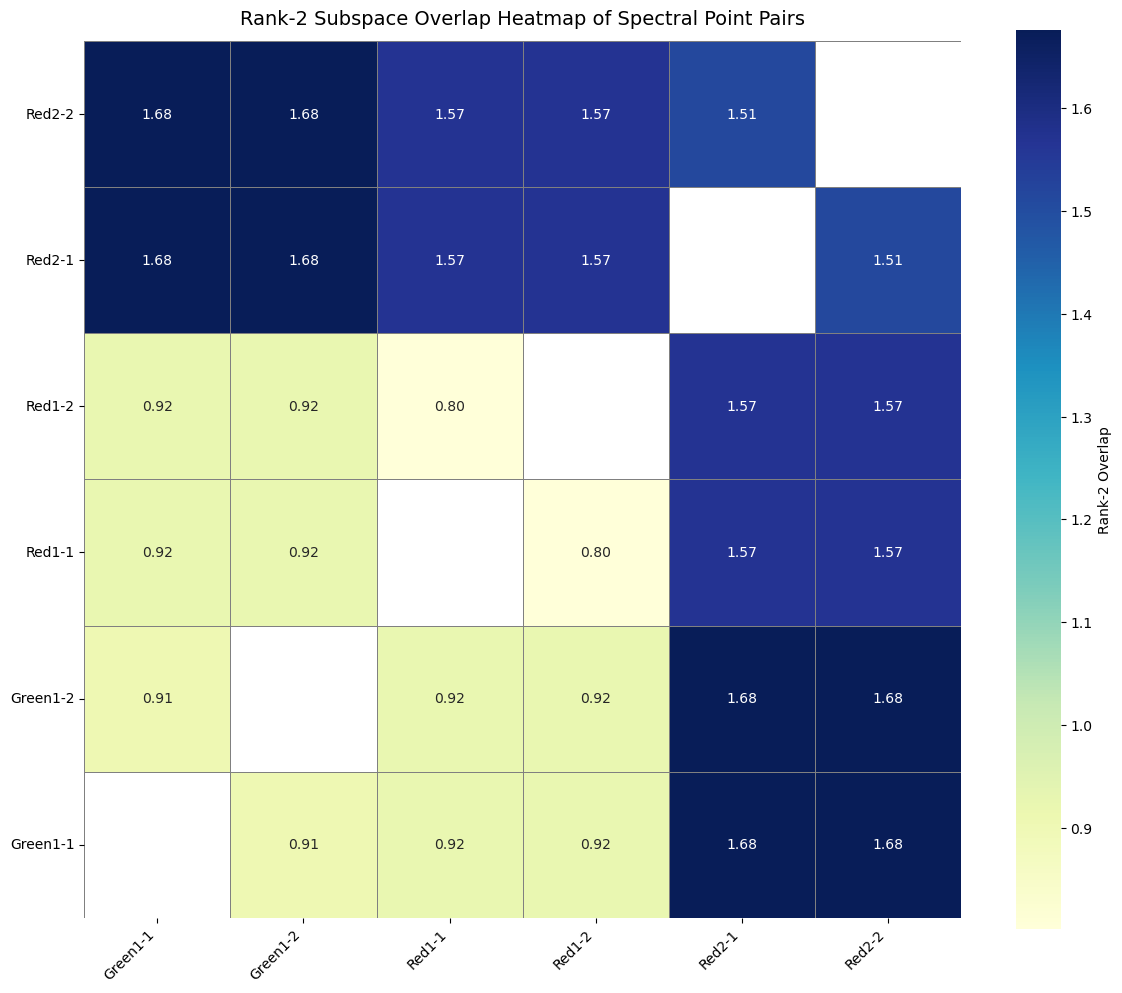

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# df_rank2 must contain:
# - "ComboLabel", e.g., "Green2-1 + Red2-2"
# - "Rank2_Overlap_q", numeric

# Collect unique point labels from pair strings
all_labels = sorted(set(sum([label.split(' + ') for label in df_rank2['ComboLabel']], [])))

# Initialize a symmetric matrix
heatmap_matrix = pd.DataFrame(np.nan, index=all_labels, columns=all_labels)

# Fill pairwise values
for _, row in df_rank2.iterrows():
    a, b = row['ComboLabel'].split(' + ')
    heatmap_matrix.loc[a, b] = row['Rank2_Overlap_q']
    heatmap_matrix.loc[b, a] = row['Rank2_Overlap_q']

# Do not plot diagonal
np.fill_diagonal(heatmap_matrix.values, np.nan)

# Top-5 combinations (by overlap)
top5 = df_rank2.nlargest(5, 'Rank2_Overlap_q')

# Plot heatmap
plt.figure(figsize=(12, 10))
ax = sns.heatmap(
    heatmap_matrix, annot=True, fmt=".2f", cmap="YlGnBu", square=True,
    cbar_kws={'label': 'Rank-2 Overlap'}, linewidths=0.5, linecolor='gray'
)

plt.title("Rank-2 Subspace Overlap Heatmap of Spectral Point Pairs", fontsize=14, pad=12)

# (Optional) highlight Top-5 with red rectangles

# Axis formatting
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
ax.invert_yaxis()

plt.tight_layout()
plt.show()


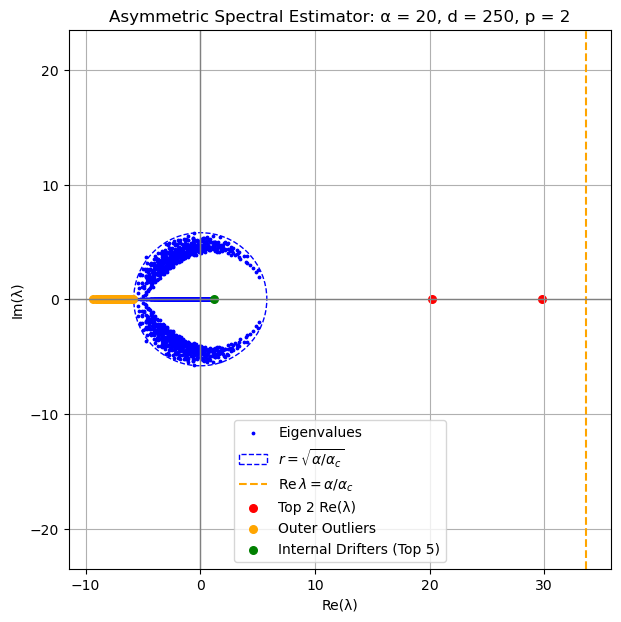

         Type        λ (eigval)  Alignment Score
0       Red-1  29.7716+ 0.0000j           0.8691
1       Red-2  20.2481+ 0.0000j           0.6929
2    Orange-1  -9.3299+ 0.0000j           0.1803
3    Orange-2  -9.1089+ 0.0000j           0.2054
4    Orange-3  -8.9167+ 0.0000j           0.1639
5    Orange-4  -8.8381+ 0.0000j           0.1644
6    Orange-5  -8.6241+ 0.0000j           0.0882
7    Orange-6  -8.4083+ 0.0000j           0.0825
8    Orange-7  -8.3637+ 0.0000j           0.0627
9    Orange-8  -8.2722+ 0.0000j           0.0826
10   Orange-9  -8.2409+ 0.0000j           0.2931
11  Orange-10  -8.1294+ 0.0000j           0.0539
12  Orange-11  -8.0149+ 0.0000j           0.0923
13  Orange-12  -7.9165+ 0.0000j           0.0718
14  Orange-13  -7.7250+ 0.0000j           0.1638
15  Orange-14  -7.6746+ 0.0000j           0.0747
16  Orange-15  -7.5677+ 0.0000j           0.1252
17  Orange-16  -7.5080+ 0.0000j           0.2839
18  Orange-17  -7.4087+ 0.0000j           0.0702
19  Orange-18  -7.23

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from numpy.linalg import norm
from scipy.linalg import qr
import pandas as pd

# Alignment metric
def alignment_score(W_hat, W_star):
    Q1, _ = qr(W_hat, mode='economic')
    Q2, _ = qr(W_star, mode='economic')
    overlap = Q1.T @ Q2
    _, s, _ = np.linalg.svd(overlap)
    return np.mean(s)

# Subspace extraction and alignment for a single eigenvalue
def extract_W_from_eigenvectors(eigvecs_np, eigval_target, X, W_star, p=2, label=""):
    idx = np.argmin(np.abs(eigvals_np - eigval_target))
    v_hat = eigvecs_np[:, idx]
    V = v_hat.reshape(-1, p)
    U = (X.cpu().numpy().T) @ V
    W_hat = U / np.linalg.norm(U, axis=0, keepdims=True)
    score = alignment_score(W_hat, W_star.cpu().numpy())
    return (label, eigval_target, score)

# Eigen decomposition
eigvals, eigvecs = torch.linalg.eig(L)
eigvals_np = eigvals.cpu().numpy()
eigvecs_np = eigvecs.cpu().numpy()
W_star_np = W_star.cpu().numpy()
d = W_star_np.shape[0]

# Spectral geometry parameters
R = np.sqrt(alpha / alpha_c)          # circle radius
thresh_ext = alpha / alpha_c          # vertical threshold

# Real-eigenvalue filter
real_mask = np.isclose(eigvals_np.imag, 0.0, atol=1e-6)
eigvals_real_only = eigvals_np[real_mask]

# Red: two largest real parts
red_vals = sorted(eigvals_real_only, key=lambda z: z.real, reverse=True)[:2]

# Orange: outside the circle and not in red
orange_candidates = [z for z in eigvals_real_only if abs(z) > R]
orange_vals = [z for z in orange_candidates if z not in red_vals]

# Green: inside the circle, top real parts (here taking 1)
green_candidates = [z for z in eigvals_real_only if abs(z) <= R]
green_vals = sorted(green_candidates, key=lambda z: z.real, reverse=True)[:1]

# Visualization
plt.figure(figsize=(7, 7))
plt.scatter(eigvals_np.real, eigvals_np.imag, color="blue", s=3, label="Eigenvalues")
circle = plt.Circle((0, 0), R, color="blue", linestyle="--", fill=False, label=r"$r = \sqrt{\alpha/\alpha_c}$")
plt.gca().add_artist(circle)
plt.axvline(thresh_ext, color="orange", linestyle="--", label=r"$\mathrm{Re}\,\lambda = \alpha/\alpha_c$")

plt.scatter([z.real for z in red_vals], [z.imag for z in red_vals],
            color="red", s=30, label="Top 2 Re(λ)")
if orange_vals:
    plt.scatter([z.real for z in orange_vals], [z.imag for z in orange_vals],
                color="orange", s=30, label="Outer Outliers")
if green_vals:
    plt.scatter([z.real for z in green_vals], [z.imag for z in green_vals],
                color="green", s=30, label="Internal Drifters (Top 5)")

plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)
plt.xlabel("Re(λ)")
plt.ylabel("Im(λ)")
plt.title(f"Asymmetric Spectral Estimator: α = {alpha}, d = {d}, p = 2")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()

# Alignment evaluation
results = []
for i, val in enumerate(red_vals):
    results.append(extract_W_from_eigenvectors(eigvecs_np, val, X, W_star, p=2, label=f"Red-{i+1}"))
for i, val in enumerate(orange_vals):
    results.append(extract_W_from_eigenvectors(eigvecs_np, val, X, W_star, p=2, label=f"Orange-{i+1}"))
for i, val in enumerate(green_vals):
    results.append(extract_W_from_eigenvectors(eigvecs_np, val, X, W_star, p=2, label=f"Green-{i+1}"))

# Tabular output
df = pd.DataFrame(results, columns=["Type", "λ (eigval)", "Alignment Score"])
pd.set_option("display.precision", 4)
print(df)


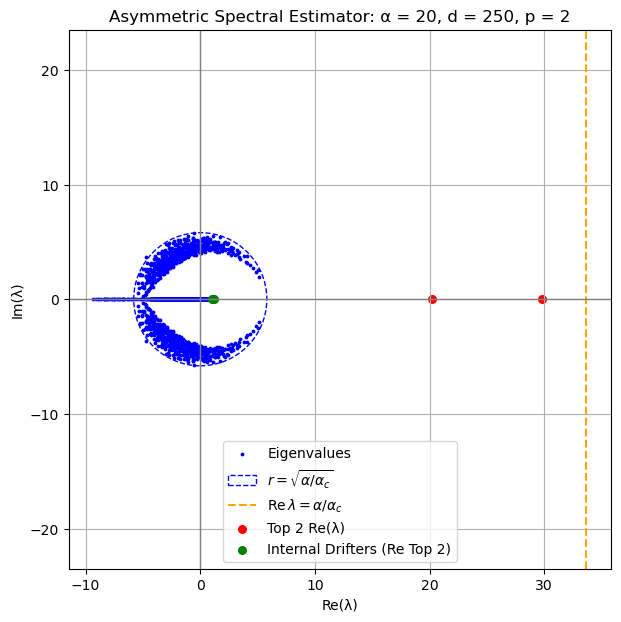

      Type        λ (eigval)  Alignment Score
0    Red-1  29.7716+ 0.0000j           0.8691
1    Red-2  20.2481+ 0.0000j           0.6929
2  Green-1   1.2111+ 0.0000j           0.5971
3  Green-2   1.0147+ 0.0000j           0.4183


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from numpy.linalg import norm
from scipy.linalg import qr
import pandas as pd

# Alignment metric
def alignment_score(W_hat, W_star):
    Q1, _ = qr(W_hat, mode='economic')
    Q2, _ = qr(W_star, mode='economic')
    overlap = Q1.T @ Q2
    _, s, _ = np.linalg.svd(overlap)
    return np.mean(s)

# Subspace extraction and alignment for a single eigenvalue
def extract_W_from_eigenvectors(eigvecs_np, eigval_target, X, W_star, p=2, label=""):
    idx = np.argmin(np.abs(eigvals_np - eigval_target))
    v_hat = eigvecs_np[:, idx]
    V = v_hat.reshape(-1, p)
    U = (X.cpu().numpy().T) @ V
    W_hat = U / np.linalg.norm(U, axis=0, keepdims=True)
    score = alignment_score(W_hat, W_star.cpu().numpy())
    return (label, eigval_target, score)

# Eigen decomposition
eigvals, eigvecs = torch.linalg.eig(L)
eigvals_np = eigvals.cpu().numpy()
eigvecs_np = eigvecs.cpu().numpy()
W_star_np = W_star.cpu().numpy()
d = W_star_np.shape[0]

# Spectral thresholds
R = np.sqrt(alpha / alpha_c)          # circle radius
thresh_ext = alpha / alpha_c          # vertical reference line

# Keep only real eigenvalues
real_mask = np.isclose(eigvals_np.imag, 0.0, atol=1e-6)
eigvals_real_only = eigvals_np[real_mask]

# Red: two largest real parts
red_vals = sorted(eigvals_real_only, key=lambda z: z.real, reverse=True)[:2]

# Orange: outside circle, excluding red
orange_candidates = [z for z in eigvals_real_only if abs(z) > R]
orange_vals = [z for z in orange_candidates if z not in red_vals]

# Green: inside circle, largest real parts (top 1)
green_candidates = [z for z in eigvals_real_only if abs(z) <= R]
green_vals = sorted(green_candidates, key=lambda z: z.real, reverse=True)[:1]

# Visualization
plt.figure(figsize=(7, 7))
plt.scatter(eigvals_np.real, eigvals_np.imag, color="blue", s=3, label="Eigenvalues")
circle = plt.Circle((0, 0), R, color="blue", linestyle="--", fill=False, label=r"$r = \sqrt{\alpha/\alpha_c}$")
plt.gca().add_artist(circle)
plt.axvline(thresh_ext, color="orange", linestyle="--", label=r"$\mathrm{Re}\,\lambda = \alpha/\alpha_c$")

plt.scatter([z.real for z in red_vals], [z.imag for z in red_vals],
            color="red", s=30, label="Top 2 Re(λ)")
if orange_vals:
    plt.scatter([z.real for z in orange_vals], [z.imag for z in orange_vals],
                color="orange", s=30, label="Outer Outliers")
if green_vals:
    plt.scatter([z.real for z in green_vals], [z.imag for z in green_vals],
                color="green", s=30, label="Internal Drifters (Top 5)")

plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)
plt.xlabel("Re(λ)")
plt.ylabel("Im(λ)")
plt.title(f"Asymmetric Spectral Estimator: α = {alpha}, d = {d}, p = 2")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()

# Alignment evaluation
results = []

for i, val in enumerate(red_vals):
    results.append(extract_W_from_eigenvectors(eigvecs_np, val, X, W_star, p=2, label=f"Red-{i+1}"))

for i, val in enumerate(orange_vals):
    results.append(extract_W_from_eigenvectors(eigvecs_np, val, X, W_star, p=2, label=f"Orange-{i+1}"))

for i, val in enumerate(green_vals):
    results.append(extract_W_from_eigenvectors(eigvecs_np, val, X, W_star, p=2, label=f"Green-{i+1}"))

# Tabular output
df = pd.DataFrame(results, columns=["Type", "λ (eigval)", "Alignment Score"])
pd.set_option("display.precision", 4)
print(df)
